# Learning Canonical Transformations to Conserved Quantities

## Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Seeking Constants of Motion

We are going to seek a canonical transformation to variables $q_\alpha$, $\pi_\alpha$ in which the radial coordinates

$$
\rho_\alpha = \sqrt{q_\alpha^2 + \pi_\alpha^2}
$$

are conserved. This means that we express the transformed Hamiltonian as $H'(q,\pi)\equiv H(x(q,\pi), p(q,\pi))$ and then try to set

$$
q_\alpha \dot q_\alpha +\pi_\alpha \dot \pi_\alpha=q_\alpha \frac{\partial H'}{\partial \pi_\alpha}-\pi_\alpha \frac{\partial H'}{\partial q_\alpha}=0,
$$

which suggests the loss function

$$
\ell(q,\pi) = \sum_\alpha \left(q_\alpha \frac{\partial H'}{\partial \pi_\alpha}-\pi_\alpha \frac{\partial H'}{\partial q_\alpha}\right)^2,
$$

which could be evaluated e.g. on i.i.d. Gaussian variates. Compared to the trajectory approach:

1. We don't need to solve an ODE, but
2. We do need to differentiate to find the gradients.

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann, parameterized_oscillator
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP, IrrotationalMLP, LinearSymplecticTwoByTwo
from utils import visualize_chain_bijector_1d, extract_q_p, join_q_p, is_symplectic, run_eagerly

../hamiltonians.py:28: DeprecationWarning: invalid escape sequence \s
  """1/4 \sum_{i,j}^N J_{ij}^2 + 1/2 \sum_{i=1}^N k_i q_i^2"""
../hamiltonians.py:43: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:54: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:63: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:72: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:81: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:90: DeprecationWarning: invalid escape sequence \s
  """


In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

In [4]:
N = 3
ks = [0.9743002 , 0.15526697, 0.46813834] # Just to fix some values
ks_tensor = tf.constant(ks, dtype=tf.float32, name="ks")
# ks_tensor = tf.constant([1,1,1], dtype=tf.float32, name="ks")

## Form Transformation by Chaining Bijectors

The idea is to map _from_ trajectories _to_ the phase plane of action angle variables, imposing the condition that the distribution factorizes.

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks_tensor), 
    'phase_space_dim': 2*N, 
    'batch_size': 1024,    # Mini batch size 
    'stack_size': 2}        # How many sets of NICE / SymplecticExchange / LinearSymplecticTwoByTwo

Here we try modeling with:

1. `IrrotationalMLP`, which directly generates an irrotational vector field, without using autodifferentiation.

2. `LinearSymplecticTwoByTwo`, which learns linear symplectic transformations on each conjugate pair. 

There is freedom to choose different activations here. Could use traditional NN nonlinearities or simpler things like `tf.square`. Since our loss now depends on gradients, should chose a smooth activation.

We don't really need squeeze, as the linear transformation includes this, so we just use NICE.

Seem to be important to do `SymplecticExchange` (an even number of times).

In [7]:
bijectors = []
for _ in range(settings['stack_size']):
    bijectors.extend([SymplecticExchange(),
                      NICE(shift_model=IrrotationalMLP(activation=tf.nn.tanh, width=32)),
                      LinearSymplecticTwoByTwo()])
# bijectors = 2*[NICE(shift_model=IrrotationalMLP(activation=tf.nn.tanh)), 
#                       SymplecticExchange(), 
#                       LinearSymplecticTwoByTwo()]
model = Chain(bijectors)

## Form the Loss

In [8]:
with tf.name_scope("loss"):
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([settings['phase_space_dim']], DTYPE))
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']), -1)
    Hprime = settings['hamiltonian'](model(z_samples))
    Hprime_grads = tf.gradients(Hprime, z_samples)[0]
    q, p = extract_q_p(z_samples)
    q_grads, p_grads = extract_q_p(Hprime_grads)
    loss = tf.reduce_mean(tf.square(q * p_grads - p * q_grads))

## Train

In [9]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

Add some summaries for tracking with TensorBoard

In [10]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

Monitor training with `tensorboard --logdir logging/`

In [11]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 78.9698
INFO:tensorflow:global_step/sec: 134.619
INFO:tensorflow:global_step/sec: 125.703
INFO:tensorflow:global_step/sec: 133.07
INFO:tensorflow:global_step/sec: 129.378
INFO:tensorflow:global_step/sec: 124.211
INFO:tensorflow:global_step/sec: 125.927
INFO:tensorflow:global_step/sec: 122.311
INFO:tensorflow:global_step/sec: 138.095
INFO:tensorflow:global_step/sec: 108.981
INFO:tensorflow:global_step/sec: 89.269
INFO:tensorflow:global_step/sec: 86.9604
INFO:tensorflow:global_step/sec: 103.934
INFO:tensorflow:global_step/sec: 104.484
INFO:tensorflow:global_step/sec: 107.404
INFO:tensorflow:global_step/sec: 113.658
INFO:tensorflow:global_step/sec: 107.064
INFO:tensorflow:global_step/sec: 118.912
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 124.583
INFO:tensorflow:global_step/sec: 132.306
INFO:tensorflow:global_step/sec: 133.159
INFO:tensorflow:global_step/sec: 108.314
INFO:tensorflow:global_step/sec: 124.791
INFO:tensorflow:global_step/sec: 141.27
INFO:tensorflow:global_step/sec: 140.484
INFO:tensorflow:global_step/sec: 128.684
INFO:tensorflow:global_step/sec: 116.371
INFO:tensorflow:global_step/sec: 124.38
INFO:tensorflow:global_step/sec: 130.62
INFO:tensorflow:global_step/sec: 114.691
INFO:tensorflow:global_step/sec: 114.387
INFO:tensorflow:global_step/sec: 140.3
INFO:tensorflow:global_step/sec: 130.524
INFO:tensorflow:global_step/sec: 132.375
INFO:tensorflow:global_step/sec: 125.266
INFO:tensorflow:global_step/sec: 124.941
INFO:tensorflow:global_step/sec: 128.108
INFO:tensorflow:global_step/sec: 134.374
INFO:tensorflow:global_step/sec: 136.569
INFO:tensorflow:global_step/sec: 119.177
INFO:tensorflow:global_step/sec: 130.069
INFO:tensorflow:global_step/sec: 131.005
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 136.926
INFO:tensorflow:global_step/sec: 137.118
INFO:tensorflow:global_step/sec: 128.367
INFO:tensorflow:global_step/sec: 136.37
INFO:tensorflow:global_step/sec: 137.311
INFO:tensorflow:global_step/sec: 138.824
INFO:tensorflow:global_step/sec: 139.118
INFO:tensorflow:global_step/sec: 140.919
INFO:tensorflow:global_step/sec: 134.552
INFO:tensorflow:global_step/sec: 135.128
INFO:tensorflow:global_step/sec: 140.781
INFO:tensorflow:global_step/sec: 137.403
INFO:tensorflow:global_step/sec: 133.775
INFO:tensorflow:global_step/sec: 138.819
INFO:tensorflow:global_step/sec: 138.848
INFO:tensorflow:global_step/sec: 139.384
INFO:tensorflow:global_step/sec: 131.958
INFO:tensorflow:global_step/sec: 137.266
INFO:tensorflow:global_step/sec: 140.13
INFO:tensorflow:global_step/sec: 136.039
INFO:tensorflow:global_step/sec: 137.819
INFO:tensorflow:global_step/sec: 132.685
INFO:tensorflow:global_step/sec: 132.969
INFO:tensorflow:global_step/sec: 137.354
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 138.599
INFO:tensorflow:global_step/sec: 140.755
INFO:tensorflow:global_step/sec: 138.094
INFO:tensorflow:global_step/sec: 118.008
INFO:tensorflow:global_step/sec: 129.728
INFO:tensorflow:global_step/sec: 140.129
INFO:tensorflow:global_step/sec: 132.392
INFO:tensorflow:global_step/sec: 131.235
INFO:tensorflow:global_step/sec: 135.002
INFO:tensorflow:global_step/sec: 138.926
INFO:tensorflow:global_step/sec: 138.802
INFO:tensorflow:global_step/sec: 135.956
INFO:tensorflow:global_step/sec: 139.128
INFO:tensorflow:global_step/sec: 133.27
INFO:tensorflow:global_step/sec: 137.415
INFO:tensorflow:global_step/sec: 138.646
INFO:tensorflow:global_step/sec: 136.664
INFO:tensorflow:global_step/sec: 139.903
INFO:tensorflow:global_step/sec: 139.391
INFO:tensorflow:global_step/sec: 137.056
INFO:tensorflow:global_step/sec: 132.164
INFO:tensorflow:global_step/sec: 135.676
INFO:tensorflow:global_step/sec: 137.707
INFO:tensorflow:global_step/sec: 138.829
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 132.769
INFO:tensorflow:global_step/sec: 132.268
INFO:tensorflow:global_step/sec: 138.107
INFO:tensorflow:global_step/sec: 133.084
INFO:tensorflow:global_step/sec: 132.579
INFO:tensorflow:global_step/sec: 124.45
INFO:tensorflow:global_step/sec: 139.778
INFO:tensorflow:global_step/sec: 136.071
INFO:tensorflow:global_step/sec: 134.292
INFO:tensorflow:global_step/sec: 136.065
INFO:tensorflow:global_step/sec: 116.208
INFO:tensorflow:global_step/sec: 119.546
INFO:tensorflow:global_step/sec: 114.141
INFO:tensorflow:global_step/sec: 116.604
INFO:tensorflow:global_step/sec: 121.997
INFO:tensorflow:global_step/sec: 139.887
INFO:tensorflow:global_step/sec: 137.818
INFO:tensorflow:global_step/sec: 140.391
INFO:tensorflow:global_step/sec: 133.19
INFO:tensorflow:global_step/sec: 131.101
INFO:tensorflow:global_step/sec: 119.138
INFO:tensorflow:global_step/sec: 108.28
INFO:tensorflow:global_step/sec: 129.001
INFO:tensorflow:global_step/sec: 130.15
INFO:tensorflow:glob

KeyboardInterrupt: 

## Look at the Learned Representation

Load the saved model. If not training, first evaluate all cells _except_ for those in the __Train__ section. 

In [12]:
traindir = "../logging"
saver = tf.train.Saver()

In [13]:
ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-76738


How do the trajectories look in the phase planes of the new variables? 

In [47]:
def hamiltons_equations(H):
    def flow(phase_space_point, t):
        phase_space_point = tf.reshape(phase_space_point, [1,-1,1])
        H_grads = tf.gradients(H(phase_space_point), phase_space_point)[0]
        dHdq, dHdp = extract_q_p(H_grads)
        flow_vec = join_q_p(dHdp, -dHdq)
        return flow_vec[0,:,0]
    return flow

def hamiltonian_traj(H, init_state, time=100, steps=200, rtol=1e-04, atol=1e-6):
    t = tf.linspace(0.0, time, num=steps)
    tensor_state = tf.contrib.integrate.odeint(hamiltons_equations(H), init_state, t, rtol, atol)
    return tensor_state

In [48]:
init_state = base_dist.sample(1)[0]
traj = sess.run(hamiltonian_traj(settings['hamiltonian'], init_state, time=20))
x1, y1, x2, y2, x3, y3 = traj.T

In [49]:
trans_traj = sess.run(model.inverse(tf.expand_dims(traj, axis=-1)))
q1, p1, q2, p2, q3, p3 = trans_traj[:,:,0].T

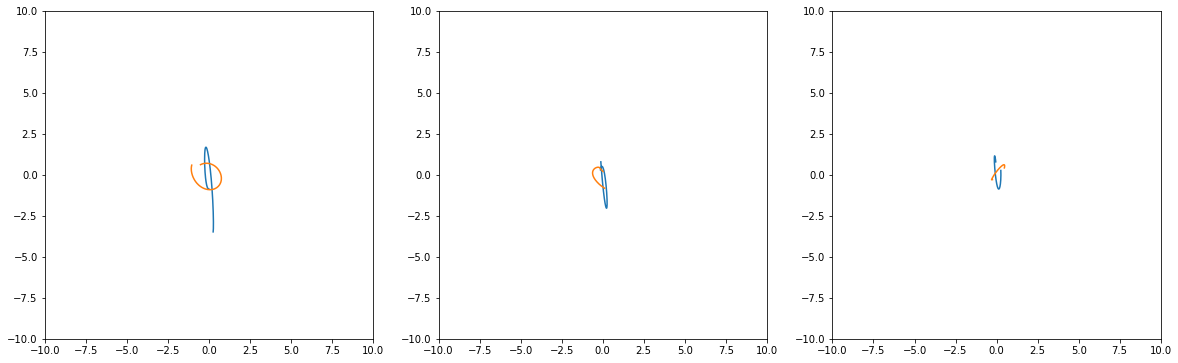

In [50]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.plot(x1, y1)
plt.plot(q1, p1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 2)
plt.plot(x2, y2)
plt.plot(q2, p2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 3)
plt.plot(x3, y3)
plt.plot(q3, p3)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')


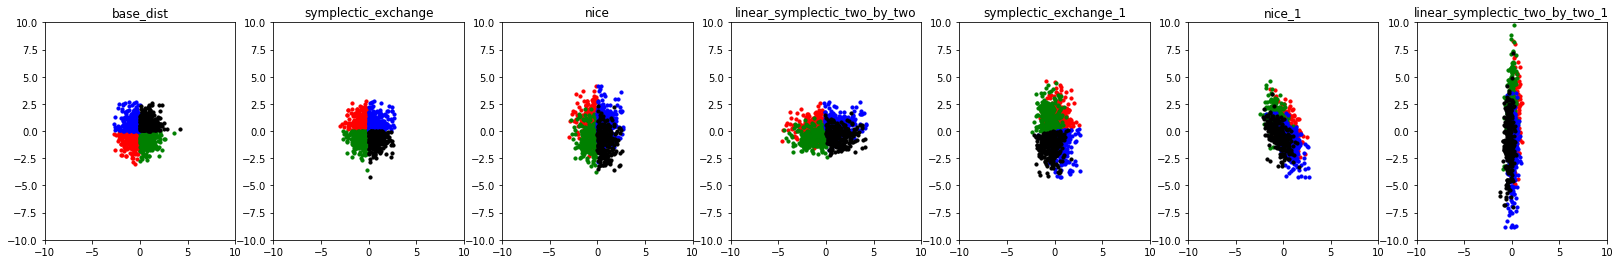

In [43]:
x = sess.run(z_samples)
samples = [x]
names = ["base_dist"]
for bijector in model.bijectors:
    x = sess.run(bijector(x))
    samples.append(x)
    names.append(bijector.name)
f, arr = plt.subplots(1, len(samples), figsize=(4 * (len(samples)), 4))
X0 = samples[0][:,:2,0]
for i, sample in enumerate(samples):
    X1 = sample[:,:2,0]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])